In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving summaries_train.csv to summaries_train.csv
Saving prompts_train.csv to prompts_train.csv


# chargement des dataset

In [ ]:
#definition des variable
prompt_path='prompts_train.csv'
summaries_path='summaries_train.csv'


# Lire les fichiers CSV
prompt_df = pd.read_csv(prompt_path)
summaries_df = pd.read_csv(summaries_path)

In [ ]:
prompt_df.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [ ]:
summaries_df.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [ ]:
print(f"summaries_df shape = {summaries_df.shape}\nprompt_df shape = {prompt_df.shape}")

summaries_df shape = (7165, 5)
prompt_df shape = (4, 4)


# analyse de colonne

## missing values

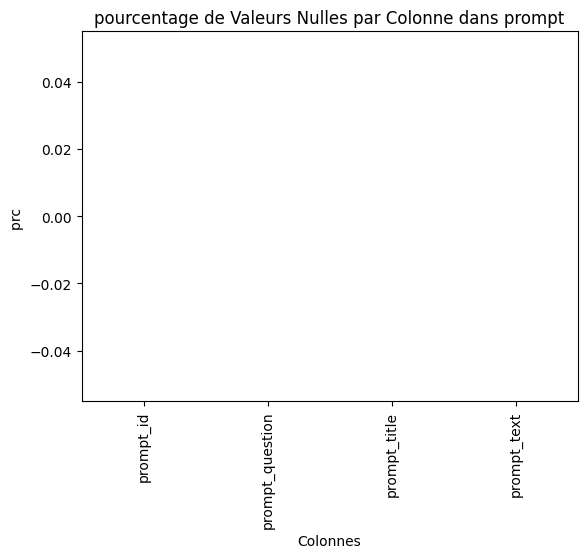

In [ ]:
# Calculer le pourcentage de valeurs nulles pour chaque colonne dans prompt
prompt_null_counts = prompt_df.isnull().sum() / prompt_df.shape[0]*100

# Créer un graphique à barres pour les valeurs nulles
prompt_null_counts.plot(kind='bar')
plt.title('pourcentage de Valeurs Nulles par Colonne dans prompt')
plt.xlabel('Colonnes')
plt.ylabel('prc ')
plt.show()

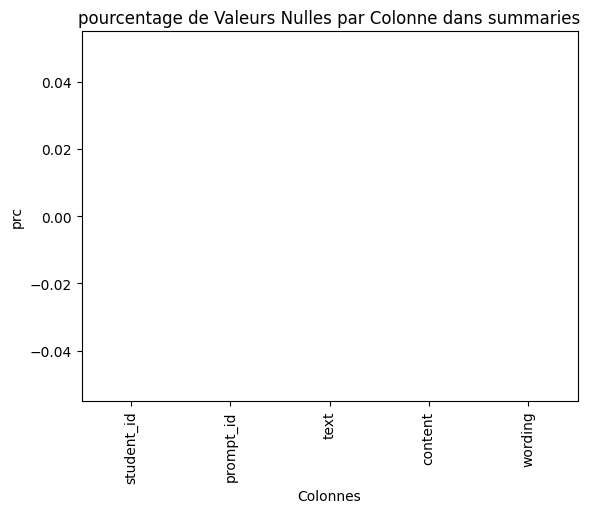

In [ ]:
# Calculer le pourcentage de valeurs nulles pour chaque colonne dans summaries
summaries_null_counts = summaries_df.isnull().sum() / summaries_df.shape[0]*100

# Créer un graphique à barres pour les valeurs nulles
summaries_null_counts.plot(kind='bar')
plt.title('pourcentage de Valeurs Nulles par Colonne dans summaries')
plt.xlabel('Colonnes')
plt.ylabel('prc')
plt.show()

nos data ne contienent pas de null c'est un bon signe

## score

In [ ]:
print(f"Valeur minimale de la score : {summaries_df['content'].min()} et max : {summaries_df['content'].max()}")

Valeur minimale de la score : -1.72985945253881 et max : 3.90032610436019


## detect langue

In [ ]:
#!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=049b002c51db1903662155ebeeda9528d26c1309992ac453dcecab54084f61b0
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
from langdetect import detect

def detect_language(df):

  for col in df.columns:
    df[f'{col}']=df[col].apply(lambda text : detect(str(text)))

  return df

In [ ]:
lng_prompt=detect_language(prompt_df.drop(columns=['prompt_id']))

In [ ]:
lng_summaries=detect_language(summaries_df.drop(columns=['student_id', 'prompt_id','content', 'wording']))

In [ ]:

def show_repartition_langue(df):
  nb_col=len(df.columns)
  fig,axes=plt.subplots(1,nb_col, figsize=(5*nb_col, 3))

  if nb_col>1 :
    axes.flatten()

  for i, col in enumerate(df.columns):
    ax = axes[i] if nb_col > 1 else axes
    df[col].value_counts().plot(kind='bar', color='blue', alpha=0.7, ax=ax)
    ax.set_title(f'Répartition des langues dans {col}')

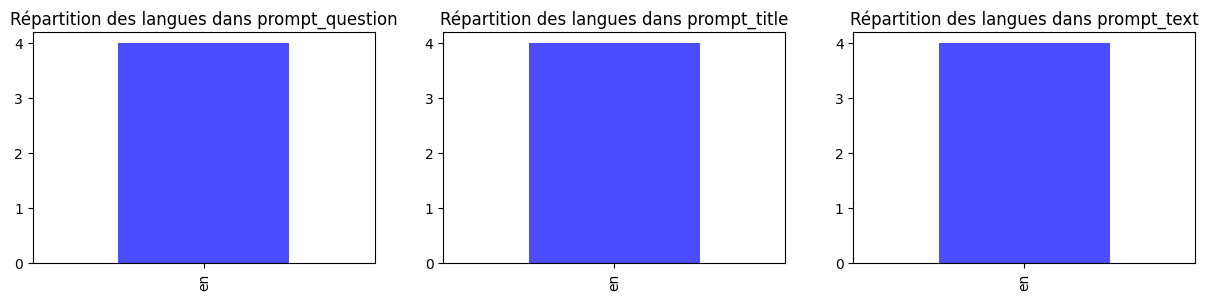

In [ ]:
show_repartition_langue(lng_prompt)

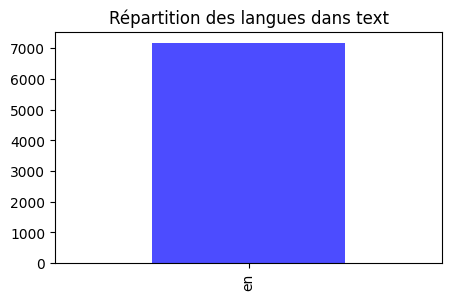

In [ ]:
show_repartition_langue(lng_summaries)

on remarque qu'on a que de l'anglais c'est un bon signe pour trouver des bibliotheque

## cleaning data

In [ ]:
#!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.0 MB/s eta 0:00:00


In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import spacy
import contractions

# Télécharger les ressources nécessaires pour NLTK
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def preprocess_text(text):

    # Convertir le texte en minuscules
    text = text.lower()

    #supprimmé des tags html si il y'en a ou "
    motif_tag = re.compile('<.*?>|"')
    text= re.sub(motif_tag, ' ', text)

    # Créer une expression régulière pour matcher les char speciaux
    caractere_special = r'[^a-zA-Z0-9\'?!]'
    # Compiler l'expression régulière
    compiled_regex = re.compile(caractere_special)
    text= re.sub(compiled_regex, ' ', text)

    # espacer un mot si il est de cette forme mot(:|?)-> mot (:|?)
    text= re.sub(r'(.*)(\?|\!)', r'\1 \2', text)

    #expend text
    # exemple didn't -> did not u -> you
    text = contractions.fix(text)

    #supprimmé des ' par exemple pour les citation
    motif_tag = re.compile('\'')
    text= re.sub(motif_tag, ' ', text)

    # supprission des espace en trop
    #text= re.sub(r'\s+', ' ', text).strip()

    # Tokenization (séparation du texte en mots)
    tokens = word_tokenize(text)

    # Supprimer les stopwords (mots blanc)
    stop_words = set(stopwords.words('english'))
    tokens = [mot for mot in tokens if mot not in stop_words]

    return ' '.join(tokens)

### teste de la fonction

In [ ]:
summaries_df.loc[2]['text']

'In Egypt, there were many occupations and social classes involved in day-to-day living. In many instances if you were at the bottom of the social ladder you could climb up, you didn\'t have to stay a peasant you could work to bring your status up. Everyone worshipped the gods Ra, Osiris, and Isis, but also they would worship their pharaohs like gods as well. Under the pharaohs were the priests, they had the responsibility to entertain or please the said god. The Chain of Command was placed to keep everyone in check, not one person could handle all the civilians and treasures without any aid. Like the tax collector, called a vizier like stated they were in charge of collecting the peoples\' tax. They were also one of the rare instances who were able to read and write, that\'s how they were granted "vizier" Also the soldiers did many things as they would fight in wars or "quelled domestic uprisings". They were in charge of getting the slaves, farmers, and peasants to build palaces or th

In [ ]:
preprocess_text(summaries_df.loc[2]['text'])

'egypt many occupations social classes involved day day living many instances bottom social ladder could climb stay peasant could work bring status everyone worshipped gods ra osiris isis also would worship pharaohs like gods well pharaohs priests responsibility entertain please said god chain command placed keep everyone check one person could handle civilians treasures without aid like tax collector called vizier like stated charge collecting peoples tax also one rare instances able read write granted vizier also soldiers many things would fight wars quelled domestic uprisings charge getting slaves farmers peasants build palaces famous ancient pyramids skilled hardworking workers occupations craftsmen women physicians would mostly make middle class people creative craftsmen would often make jewelry papyrus products pottery tools many useful things people may need course would need merchants sell goods people would pay'

In [ ]:
prompt_df.loc[2]['prompt_text']

'Background \r\nThe Third Wave experiment took place at Cubberley High School in Palo Alto, California during the first week of April 1967. History teacher Ron Jones, finding himself unable to explain to his students how people throughout history followed the crowd even when terrible things were happening, decided to demonstrate it to his students through an experiment. Jones announced that he was starting a movement aimed to eliminate democracy. Jones named the movement “The Third Wave” as a symbol of strength, referring to the mythical belief that the third in a series of waves is the strongest. One of the central points of this movement was that democracy’s main weakness is that it favors the individual over the whole community. Jones emphasized this main point of the movement when he created this catchy motto: “Strength through discipline, strength through community, strength through action, strength through pride.” \r\nThe Experiment \r\nJones started the first day of the experime

In [ ]:
preprocess_text(prompt_df.loc[2]['prompt_text'])

'background third wave experiment took place cubberley high school palo alto california first week april 1967 history teacher ron jones finding unable explain students people throughout history followed crowd even terrible things happening decided demonstrate students experiment jones announced starting movement aimed eliminate democracy jones named movement third wave symbol strength referring mythical belief third series waves strongest one central points movement democracy main weakness favors individual whole community jones emphasized main point movement created catchy motto strength discipline strength community strength action strength pride experiment jones started first day experiment emphasizing simple things like proper seating drilled students extensively got right proceeded enforce strict classroom discipline emerging authoritarian figure resulted dramatic improvements efficiency orderliness class first day session ended rules jones intended one day experiment students sit

### netoyage des features texte

In [ ]:
def transform_df(df,features):

  for col in features :
    df[col]=df[col].apply(preprocess_text)

  return df

In [ ]:
columns_to_transform=prompt_df.columns[1:]
clean_prompt=transform_df(prompt_df.copy(),columns_to_transform)

In [ ]:
columns_to_transform=[summaries_df.columns[2]]
clean_summaries=transform_df(summaries_df.copy(),columns_to_transform)

### statistic sur les textes

In [ ]:
def show_stat(df,features):

  d={'moyenne': [], 'ecart type': []}

  for col in features:
    #longueur du text
    df[col]=df[col].apply(lambda text : len(text.split(' ')))

    d['moyenne'].append(df[col].mean())
    d['ecart type'].append(df[col].std())

  nb_col=len(features)
  fig,axes=plt.subplots(1,nb_col, figsize=(6*nb_col, 3))

  if nb_col>1 :
    axes.flatten()

  for i, col in enumerate(features):
    ax = axes[i] if nb_col > 1 else axes
    ax.hist(df[col], bins=100, density=True,color='skyblue', edgecolor='black')
    ax.set_title(f'densité de la taille de text dans {col}')

  df_show = pd.DataFrame(d, index=features)
  print(df_show)

                 moyenne  ecart type
prompt_question     86.0   36.340978
prompt_title        14.0    7.874008
prompt_text       2392.5  372.234245


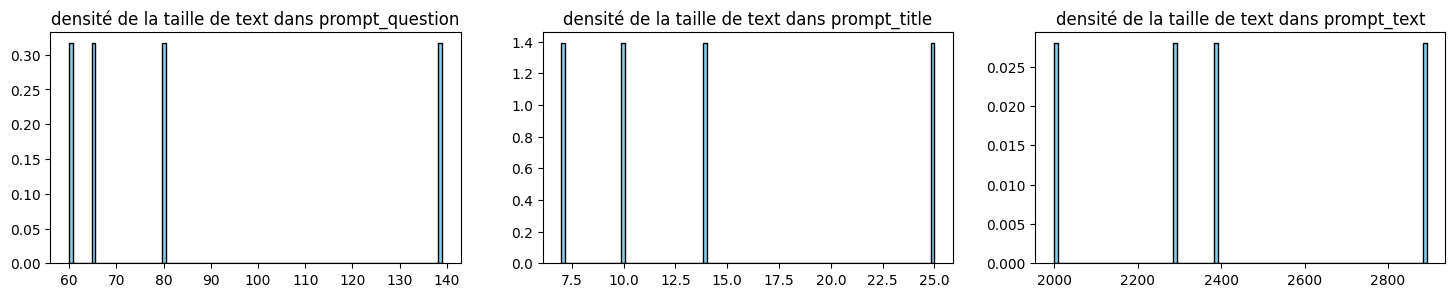

In [ ]:
features=clean_prompt.columns[1:]
show_stat(clean_prompt.copy(),features)

         moyenne  ecart type
text  260.168179  196.349504


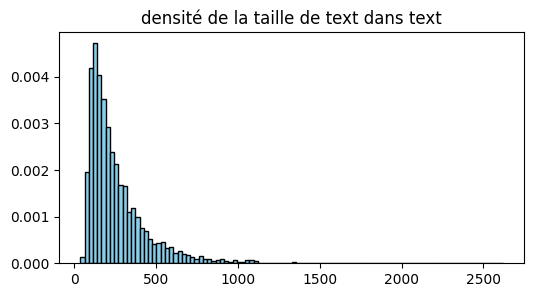

In [ ]:
features=[clean_summaries.columns[2]]
show_stat(clean_summaries.copy(),features)

la plupart de nos text sont de grande taille donc pour utliser des rnn simple forcement on a pas de grande performence seulement si on utilise des architecture deep rnn mais je suis pas sur donc je vais opté pour des transformers directement

# creation du data set

comme je n'ai pas bcq de données j'ai opté pour crée le data set directement ici et le sauvgarder

## prompt

je trouve que title n'as pas trop de pertinance car avec la question et le text normalement sa suffirai

In [ ]:
clean_prompt

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,summarize least 3 elements ideal tragedy descr...,tragedy,chapter 13 sequel already said must proceed co...
1,3b9047,complete sentences summarize structure ancient...,egyptian social structure,egyptian society structured like pyramid top g...
2,814d6b,summarize third wave developed short period ti...,third wave,background third wave experiment took place cu...
3,ebad26,summarize various ways factory would use cover...,excerpt jungle,one member trimming beef cannery another worki...


In [ ]:
clean_prompt=clean_prompt.drop(columns=['prompt_title'])

# j'ai rajouter des tokens pour distinguer la question du text
clean_prompt['prompt'] = 'start_text ' + clean_prompt['prompt_text'] + ' end_text ' + 'start_question ' + clean_prompt['prompt_question'] + ' end_question'

clean_prompt=clean_prompt.drop(columns=['prompt_text', 'prompt_question'])

clean_prompt

,prompt_id,prompt
0,39c16e,start_text chapter 13 sequel already said must...
1,3b9047,start_text egyptian society structured like py...
2,814d6b,start_text background third wave experiment to...
3,ebad26,start_text one member trimming beef cannery an...


## summaries

In [ ]:
clean_summaries=clean_summaries.drop(columns=['wording','student_id'])

content est un score \
j'applique une tanh sur content pour normaliser les données entre -1 1 \
tanh est croissante donc la notion de score est preservé



In [ ]:
clean_summaries['content'] = np.tanh(clean_summaries['content'])

In [ ]:
clean_summaries

,prompt_id,text,content
0,814d6b,third wave experimentto see people reacted new...,0.202830
1,ebad26,would rub soda make smell go away would bad sm...,-0.499248
2,3b9047,egypt many occupations social classes involved...,0.996177
3,3b9047,highest class pharaohs people gods 2nd highest...,-0.207554
4,814d6b,third wave developed rapidly students genuinly...,0.997132
...,...,...,...
7160,ebad26,used sorts chemical concoctions make meat seem...,0.202830
7161,3b9047,lowest classes slaves farmers slaves people ta...,-0.299024
7162,3b9047,sorta made people start working structour they...,-0.887107
7163,39c16e,ideal tragety three elements make ideal start ...,-0.374210


## fusion

In [ ]:
key='prompt_id'
dataset= clean_summaries.set_index(key).join(clean_prompt.set_index(key))

In [ ]:
dataset

,text,content,prompt
prompt_id,,,
39c16e,1 element ideal tragedy arranged complex plan ...,-0.207554,start_text chapter 13 sequel already said must...
39c16e,three elements ideal tragedy character bad mis...,-0.748808,start_text chapter 13 sequel already said must...
39c16e,aristotle states ideal tragedy complex plan we...,-0.369454,start_text chapter 13 sequel already said must...
39c16e,one element ideal tragedy complex plan imitate...,0.088649,start_text chapter 13 sequel already said must...
39c16e,3 ideal tragedy complex need make reader keeps...,-0.596237,start_text chapter 13 sequel already said must...
...,...,...,...
ebad26,paragraph two would use pickle meat would rub ...,0.908760,start_text one member trimming beef cannery an...
ebad26,first paragraph says either chop sausage also ...,-0.835044,start_text one member trimming beef cannery an...
ebad26,would piles filthy meat floor would get dirty ...,0.317387,start_text one member trimming beef cannery an...


j'ai concatené mes données car en utilisant les transformers je peux caclculé l'attention logiquement sont vraiment de perte d'info

In [ ]:
#sauvgarde du dataset
path_to_save= 'dataset.csv'

dataset.to_csv(path_to_save, index=False )